Namespace(data_file='sample_data.csv', num_epochs=100, num_samples=100, seed=1234, test_size=0.25, train_size=0.75)


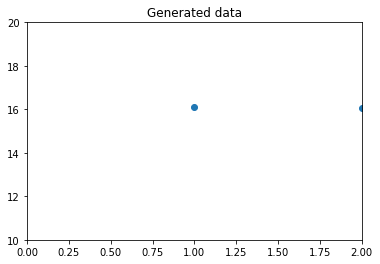

X_train: (75, 1)
y_train: (75,)
X_test: (25, 1)
y_test: (25,)
mean: [8.22952817e-17] 7.350601608872391e-17
std: [1.] 1.0
train_MSE: 29.14, test_MSE: 35.00


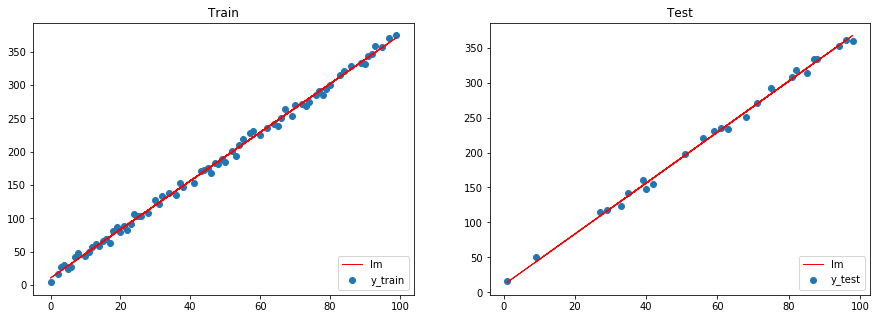

[10.50158072 14.14515288 17.78872504]
[3.64357519]
[10.50158285]


In [45]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Arguments
args = Namespace(
    seed=1234,
    data_file="sample_data.csv",
    num_samples=100,
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
)
print(args)
# Set seed for reproducability
# random.seed makes sure everytime it returns the same random numbers
np.random.seed(args.seed) 

# Generate synthetic data
def generate_data(num_samples):
    X = np.array(range(num_samples))
    random_noise = np.random.uniform(-10,10,size=num_samples)
    y = 3.65*X + 10 + random_noise # add some noise
    return X, y

# Generate random (linear) data
X, y = generate_data(args.num_samples)
data = np.vstack([X, y]).T
df = pd.DataFrame(data, columns=['X', 'y'])
df.head()

# Scatter plot
plt.title("Generated data")
plt.scatter(x=df["X"], y=df["y"])
plt.xlim(0,2)
plt.ylim(10,20)
plt.show()

# Import packages
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create data splits
X_train, X_test, y_train, y_test = train_test_split(
    df["X"].values.reshape(-1, 1), df["y"], test_size=args.test_size, 
    random_state=args.seed)
print ("X_train:", X_train.shape)
print ("y_train:", y_train.shape)
print ("X_test:", X_test.shape)
print ("y_test:", y_test.shape)

# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.values.reshape(-1,1))

# Apply scaler on training and test data
standardized_X_train = X_scaler.transform(X_train)
standardized_y_train = y_scaler.transform(y_train.values.reshape(-1,1)).ravel()
standardized_X_test = X_scaler.transform(X_test)
standardized_y_test = y_scaler.transform(y_test.values.reshape(-1,1)).ravel()


# Check
print ("mean:", np.mean(standardized_X_train, axis=0), 
       np.mean(standardized_y_train, axis=0)) # mean should be ~0
print ("std:", np.std(standardized_X_train, axis=0), 
       np.std(standardized_y_train, axis=0))   # std should be 1

# Initialize the model
lm = SGDRegressor(loss="squared_loss", penalty="none", max_iter=args.num_epochs)

# Train
lm.fit(X=standardized_X_train, y=standardized_y_train)
# Predictions (unstandardize them)
pred_train = (lm.predict(standardized_X_train) * np.sqrt(y_scaler.var_)) + y_scaler.mean_
pred_test = (lm.predict(standardized_X_test) * np.sqrt(y_scaler.var_)) + y_scaler.mean_

import matplotlib.pyplot as plt

# Train and test MSE
train_mse = np.mean((y_train - pred_train) ** 2)
test_mse = np.mean((y_test - pred_test) ** 2)
print ("train_MSE: {0:.2f}, test_MSE: {1:.2f}".format(train_mse, test_mse))

# Figure size
plt.figure(figsize=(15,5))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train, y_train, label="y_train")
plt.plot(X_train, pred_train, color="red", linewidth=1, linestyle="-", label="lm")
plt.legend(loc='lower right')

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test, y_test, label="y_test")
plt.plot(X_test, pred_test, color="red", linewidth=1, linestyle="-", label="lm")
plt.legend(loc='lower right')

# Show plots
plt.show()

# Feed in your own inputs
X_infer = np.array((0, 1, 2), dtype=np.float32)
standardized_X_infer = X_scaler.transform(X_infer.reshape(-1, 1))
pred_infer = (lm.predict(standardized_X_infer) * np.sqrt(y_scaler.var_)) + y_scaler.mean_
print (pred_infer)
df.head(3)

# Unstandardize coefficients 
coef = lm.coef_ * (y_scaler.scale_/X_scaler.scale_)
intercept = lm.intercept_ * y_scaler.scale_ + y_scaler.mean_ - np.sum(coef*X_scaler.mean_)
print (coef) # ~3.65
print (intercept) # ~10